# Lab Assignment Four: The Multi-Layer Perceptron

### Load, Split, and Balance

#### Load Data
The dataframe contains 2015 American Community Survey 5-year estimates regaring about facts regarding the us census demographic. <br/>
First the data was loaded into a dataframe, where I then removed all rows with any null values. I then took the two string values, and converted them to integers without onehot encoding them. 

**Data Set** : US Census Data - https://www.kaggle.com/datasets/muonneutrino/us-census-demographic-data

In [1]:
#Import all necessary utilities
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from scipy import stats
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
import re
from scipy.special import expit
import sys
warnings.simplefilter('ignore', DeprecationWarning)

#Loading the dataset
data = pd.read_csv('../Data/acs2017_census_tract_data.csv', low_memory=False)

#Showing data
data.info()
data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74001 entries, 0 to 74000
Data columns (total 37 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   TractId           74001 non-null  int64  
 1   State             74001 non-null  object 
 2   County            74001 non-null  object 
 3   TotalPop          74001 non-null  int64  
 4   Men               74001 non-null  int64  
 5   Women             74001 non-null  int64  
 6   Hispanic          73305 non-null  float64
 7   White             73305 non-null  float64
 8   Black             73305 non-null  float64
 9   Native            73305 non-null  float64
 10  Asian             73305 non-null  float64
 11  Pacific           73305 non-null  float64
 12  VotingAgeCitizen  74001 non-null  int64  
 13  Income            72885 non-null  float64
 14  IncomeErr         72885 non-null  float64
 15  IncomePerCap      73256 non-null  float64
 16  IncomePerCapErr   73256 non-null  float6

,TractId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,1001020100,Alabama,Autauga County,1845,899,946,2.4,86.3,5.2,0.0,...,0.5,0.0,2.1,24.5,881,74.2,21.2,4.5,0.0,4.6
1,1001020200,Alabama,Autauga County,2172,1167,1005,1.1,41.6,54.5,0.0,...,0.0,0.5,0.0,22.2,852,75.9,15.0,9.0,0.0,3.4
2,1001020300,Alabama,Autauga County,3385,1533,1852,8.0,61.4,26.5,0.6,...,1.0,0.8,1.5,23.1,1482,73.3,21.1,4.8,0.7,4.7
3,1001020400,Alabama,Autauga County,4267,2001,2266,9.6,80.3,7.1,0.5,...,1.5,2.9,2.1,25.9,1849,75.8,19.7,4.5,0.0,6.1
4,1001020500,Alabama,Autauga County,9965,5054,4911,0.9,77.5,16.4,0.0,...,0.8,0.3,0.7,21.0,4787,71.4,24.1,4.5,0.0,2.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73996,72153750501,Puerto Rico,Yauco Municipio,6011,3035,2976,99.7,0.3,0.0,0.0,...,0.5,0.0,3.6,26.9,1576,59.2,33.8,7.0,0.0,20.8
73997,72153750502,Puerto Rico,Yauco Municipio,2342,959,1383,99.1,0.9,0.0,0.0,...,0.0,0.0,1.3,25.3,666,58.4,35.4,6.2,0.0,26.3
73998,72153750503,Puerto Rico,Yauco Municipio,2218,1001,1217,99.5,0.2,0.0,0.0,...,3.4,0.0,3.4,23.5,560,57.5,34.5,8.0,0.0,23.0
73999,72153750601,Puerto Rico,Yauco Municipio,4380,1964,2416,100.0,0.0,0.0,0.0,...,0.0,0.0,0.0,24.1,1062,67.7,30.4,1.9,0.0,29.5


In [2]:
#Remove all rows with null values
data.dropna(inplace=True);

#Convert all String Values to Integers
data[['State', 'County']] = data[['State', 'County']].apply(lambda x: pd.factorize(x)[0])

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72718 entries, 0 to 74000
Data columns (total 37 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   TractId           72718 non-null  int64  
 1   State             72718 non-null  int64  
 2   County            72718 non-null  int64  
 3   TotalPop          72718 non-null  int64  
 4   Men               72718 non-null  int64  
 5   Women             72718 non-null  int64  
 6   Hispanic          72718 non-null  float64
 7   White             72718 non-null  float64
 8   Black             72718 non-null  float64
 9   Native            72718 non-null  float64
 10  Asian             72718 non-null  float64
 11  Pacific           72718 non-null  float64
 12  VotingAgeCitizen  72718 non-null  int64  
 13  Income            72718 non-null  float64
 14  IncomeErr         72718 non-null  float64
 15  IncomePerCap      72718 non-null  float64
 16  IncomePerCapErr   72718 non-null  float6

#### Splitting Data
Because we later plan to equalize the classes, I utilized a standard test-train split of 80% training, 20% testing. Below, we can see that the form a pretty standard grouping.

In [3]:
# Creating our data matrix (X) and our target variable (y) that we will work on from the dataframe we have
X = data[['TractId', 'State', 'County', 'TotalPop', 'Men', 'Women', 'Hispanic',
       'White', 'Black', 'Native', 'Asian', 'Pacific', 'VotingAgeCitizen',
       'Income', 'IncomeErr', 'IncomePerCap', 'IncomePerCapErr', 'Poverty',
       'Professional', 'Service', 'Office', 'Construction',
       'Production', 'Drive', 'Carpool', 'Transit', 'Walk', 'OtherTransp',
       'WorkAtHome', 'MeanCommute', 'Employed', 'PrivateWork', 'PublicWork',
       'SelfEmployed', 'FamilyWork', 'Unemployment']]
y = data.ChildPoverty.to_numpy()
print("The shape of the data matrix: " + str(X.shape))
print("The shape of the target variable: " + str(y.shape))

The shape of the data matrix: (72718, 36)
The shape of the target variable: (72718,)


In [4]:
# Dividing the data into training and testing data using an 80% training and 20% testing split.
X_train, X_test, y_train, y_test = train_test_split(X.copy(), y.copy(), test_size=0.2, random_state=0)
print("The training matrix and target shapes: " + str(X_train.shape)+ ' & ' + str(y_train.shape))
print("The testing matrix and target shapes: " + str(X_test.shape)+ ' & ' + str(y_test.shape))

The training matrix and target shapes: (58174, 36) & (58174,)
The testing matrix and target shapes: (14544, 36) & (14544,)


#### Balancing Data
Because there was such an uneven balance in the data, it is important that we balance the dataset. In order to create classes based on the data, I decided to divide the data into low poverty, average povery, high povery, and extreme. In order to find these values, I looked at the overall spread of the data. As there were only outlier values on the upper bound, I assigned each value to be based around the quartiles. We want our values to be based around the training sample because we want to prevent data snooping.

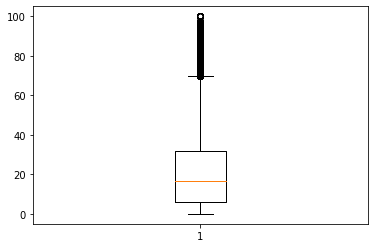

In [5]:
#original split into 4 classes : low, average, high, and extreme poverty
#Graph general boxplot to see break-up
plt.boxplot(y_train)
plt.show()

#Calculate Quartiles
Q1, median, Q3 = np.percentile(np.asarray(y_train), [25, 50, 75])
IQR = Q3 - Q1

loval = Q1 - 1.5 * IQR
hival = Q3 + 1.5 * IQR

#Calculate Classes
#Low is less than Q1, Average is between Q1-Q3, High is between Q3 and highval, extreme are outliers above highval
def classify(row):
    if row['ChildPoverty'] < Q1:
        val = 0
    elif row['ChildPoverty'] < Q3:
        val = 1
    elif row['ChildPoverty'] < hival:
        val = 2
    else : 
        val = 3
    return val

data['cp_class'] = data.apply(classify, axis=1)

#Split again to convert y_train and y_test to classes
y = data.cp_class.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X.copy(), y.copy(), test_size=0.2, random_state=0)

Based on the below graph, the bulk of the values fall into the class of average poverty and there are barely any values for extreme poverty. As this is the general understanding of how poverty should be distributed, we can assume the classes are divided well.

<BarContainer object of 4 artists>

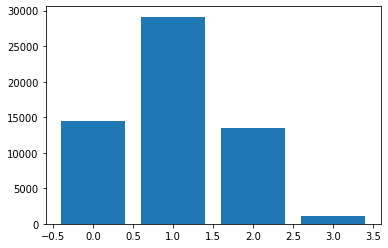

In [6]:
#Make sure there are equal number of instances in each class
#Graph of balance
plt.bar(np.unique(y_train), np.unique(y_train, return_counts=True)[1])

For training purposes, we want each class to be equally represented. In order to do that, I chose to implement a SMOTE instance to create equal number of classes. SMOTE is a Snthetic Minority Oversampling Technique which draws a random sample of the minority class, identify the k nearest neighbor, then find the vector between them. From this you are able to add a synthetic data point. This allows all the duplicated information to be close to what is present, without being a direct copy. I chose SMOTE because it increases recall at the lowest precision cost of the methods I saw. SMOTE allows for the best range of points to ensure higher accuracy. Once we have run smote on the larger dataset, we must then split back into training and testing again to continue to prevent data snooping. From the below graph, we can see that after out implementation of SMOTE, we now have equal numbers of each class in the training set. 

<BarContainer object of 4 artists>

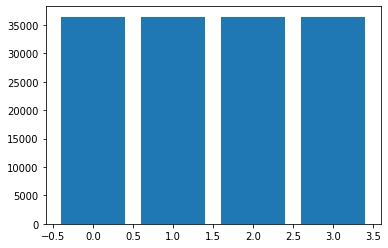

In [7]:
# Making an instance of SMOTE class 
# For oversampling of minority class
from imblearn.over_sampling import SMOTE

smote = SMOTE()
  
# Fit predictor (x variable)
# and target (y variable) using fit_resample()
X_OverSmote, y_OverSmote = smote.fit_resample(X.copy(), y.copy())
plt.bar(np.unique(y_OverSmote), np.unique(y_OverSmote, return_counts=True)[1])

**Should balancing of the dataset be done for both the training and testing set? Explain.** <br/>
Balancing should be done on just the training dataset and not the testing set. The model has already adjusted for imbalance to have equal awareness of the underrepresented classes, so it does not matter what data it is tested against. Additionally, while we want the data we train on to minimize biases, we do want the data we test against to be a reflection of the true values of the data.

### Pre-processing

#### Two-Layer Perceptron
Below is the implementation of the Two Layer Perceptron that we developed in class. 

In [8]:
# Example adapted from https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch12/ch12.ipynb
# Original Author: Sebastian Raschka

# This is the optional book we use in the course, excellent intuitions and straightforward programming examples
# please note, however, that this code has been manipulated to reflect our assumptions and notation.
import numpy as np
from scipy.special import expit
import pandas as pd
import sys

# start with a simple base classifier, which can't be fit or predicted
# it only has internal classes to be used by classes that will subclass it
class TwoLayerPerceptronBase(object):
    def __init__(self, n_hidden=30,
                 C=0.0, epochs=500, eta=0.001, random_state=None):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
            
        return onehot

    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        W1_num_elems = (self.n_features_ + 1)*self.n_hidden
        W1 = np.random.uniform(-1.0, 1.0,size=W1_num_elems)
        W1 = W1.reshape(self.n_hidden, self.n_features_ + 1) # reshape to be W
        
        W2_num_elems = (self.n_hidden + 1)*self.n_output_
        W2 = np.random.uniform(-1.0, 1.0, size=W2_num_elems)
        W2 = W2.reshape(self.n_output_, self.n_hidden + 1)
        return W1, W2
    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)
    
    @staticmethod
    def _add_bias_unit(X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            ones = np.ones((X.shape[0], 1))
            X_new = np.hstack((ones, X))
        elif how == 'row':
            ones = np.ones((1, X.shape[1]))
            X_new = np.vstack((ones, X))
        return X_new
    
    @staticmethod
    def _L2_reg(lambda_, W1, W2):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_/2.0) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2))
    
    def _cost(self,A3,Y_enc,W1,W2):
        '''Get the objective function value'''
        cost = np.mean((Y_enc-A3)**2)
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term
    
    def _feedforward(self, X, W1, W2):
        """Compute feedforward step
        """
        A1 = self._add_bias_unit(X, how='column')
        A1 = A1.T
        Z1 = W1 @ A1
        A2 = self._sigmoid(Z1)
        A2 = self._add_bias_unit(A2, how='row')
        Z2 = W2 @ A2
        A3 = self._sigmoid(Z2)
        return A1, Z1, A2, Z2, A3
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V2 = -2*(Y_enc-A3)*A3*(1-A3)  # last layer sensitivity
        V1 = A2*(1-A2)*(W2.T @ V2) # back prop the sensitivity 
        
        grad2 = V2 @ A2.T # no bias on final layer
        grad1 = V1[1:,:] @ A1.T # dont back prop sensitivity of bias
        
        
        # regularize weights that are not bias terms
        grad1[:, 1:] += W1[:, 1:] * self.l2_C
        grad2[:, 1:] += W2[:, 1:] * self.l2_C

        return grad1, grad2
    
    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, A3 = self._feedforward(X, self.W1, self.W2)
        y_pred = np.argmax(A3, axis=0)
        return y_pred

In [9]:
from sklearn.metrics import accuracy_score
# just start with the vectorized version and minibatch
class TLPMiniBatch(TwoLayerPerceptronBase):
    def __init__(self, alpha=0.0, decrease_const=0.0, shuffle=True, 
                 minibatches=1, **kwds):        
        # need to add to the original initializer 
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches
        # but keep other keywords
        super().__init__(**kwds)
        
    
    def fit(self, X, y, print_progress=False, XY_test=None):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2 = self._initialize_weights()

        rho_W1_prev = np.zeros(self.W1.shape)
        rho_W2_prev = np.zeros(self.W2.shape)

        self.cost_ = []
        self.score_ = []
        # get starting acc
        self.score_.append(np.mean(self.predict(X_data) == y_data))
        # keep track of validation, if given
        if XY_test is not None:
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            self.val_score_ = []
            self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
            
        for i in range(self.epochs):

            # adaptive learning rate
            # \frac{\eta}{1+\epsilon\cdot k}
            eta = self.eta / (1 + self.decrease_const*i)

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:

                # feedforward
                A1, Z1, A2, Z2, A3 = self._feedforward(X_data[idx],
                                                       self.W1,
                                                       self.W2)
                
                cost = self._cost(A3,Y_enc[:, idx],self.W1,self.W2)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                grad1, grad2 = self._get_gradient(A1=A1, A2=A2, A3=A3, Z1=Z1, Z2=Z2, 
                                                  Y_enc=Y_enc[:, idx],
                                                  W1=self.W1,W2=self.W2)

                # momentum calculations
                rho_W1, rho_W2 = eta * grad1, eta * grad2
                self.W1 -= (rho_W1 + (self.alpha * rho_W1_prev))
                self.W2 -= (rho_W2 + (self.alpha * rho_W2_prev))
                rho_W1_prev, rho_W2_prev = rho_W1, rho_W2

            self.cost_.append(mini_cost)
            self.score_.append(np.mean(self.predict(X_data) == y_data))
            if XY_test is not None:
                self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
            
        return self

In [10]:
# to implement the new style of objective function, 
# we just need to update the final layer calculation of the gradient
class TLPMiniBatchCrossEntropy(TLPMiniBatch):
    def _cost(self,A3,Y_enc,W1,W2):
        '''Get the objective function value'''
        cost = -np.mean(np.nan_to_num((Y_enc*np.log(A3)+(1-Y_enc)*np.log(1-A3))))
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V2 = (A3-Y_enc) # <- this is only line that changed
        V1 = A2*(1-A2)*(W2.T @ V2)
        
        grad2 = V2 @ A2.T
        grad1 = V1[1:,:] @ A1.T
        
        # regularize weights that are not bias terms
        grad1[:, 1:] += W1[:, 1:] * self.l2_C
        grad2[:, 1:] += W2[:, 1:] * self.l2_C

        return grad1, grad2

In [11]:
class TLPBetterInitial(TLPMiniBatchCrossEntropy):             
    def _initialize_weights(self):
        """Initialize weights Glorot and He normalization."""
        init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_features_ + 1))
        W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_features_ + 1))
        W1[:,:1] = 0
        
        # reduce the final layer magnitude in order to balance the size of the gradients
        # between 
        init_bound = 4*np.sqrt(6 / (self.n_output_ + self.n_hidden + 1))
        W2 = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden + 1)) 
        W2[:,:1] = 0
        
        return W1, W2

In [12]:
def analyze_two_layer_perceptron(X_train, y_train, X_test, y_test):
    vals = { 'n_hidden':30, 
         'C':0.1, 'epochs':20, 'eta':0.001, 
         'alpha':0.001, 'decrease_const':1e-5, 'minibatches':50,
         'shuffle':True,'random_state':1}

    nn_tradit = TLPMiniBatchCrossEntropy(**vals)
    nn_better = TLPBetterInitial(**vals)

    %time nn_tradit.fit(X_train, y_train, print_progress=1, XY_test=(X_test, y_test))
    %time nn_better.fit(X_train, y_train, print_progress=1, XY_test=(X_test, y_test))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 6))
    
    print_result(nn_tradit,X_train,y_train,X_test,y_test, ax1, ax2, title="Traditional",color="red")
    print_result(nn_better,X_train,y_train,X_test,y_test, ax1, ax2, title="Glorot Initial",color="blue")
    plt.show()

Utilizing Eric Larson's method in https://github.com/eclarson/MachineLearningNotebooks/blob/master/08.%20Practical_NeuralNets.ipynb, I was able to implement a function which showed us the accuracy and cost of the function as it goes on. 

In [13]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')

def print_result(nn,X_train,y_train,X_test,y_test, ax1, ax2, title="",color="red"):
    
    print("=================")
    print(title,":")
    yhat = nn.predict(X_train)
    print('Resubstitution acc:',accuracy_score(y_train,yhat))
    
    yhat = nn.predict(X_test)
    print('Validation acc:',accuracy_score(y_test,yhat))
    
    cost_avgs = [np.mean(x) for x in nn.cost_]
    ax1.plot(range(len(cost_avgs)), cost_avgs, color=color,label=title)
    ax1.set_ylabel('Cost')
        
    ax1.set_xlabel('Epochs')
    ax1.legend(loc='best')
    ax1.grid(True)
    
    if hasattr(nn,'val_score_'):
        ax2.plot(range(len(nn.val_score_)), nn.val_score_, color=color,label=title)
        ax2.set_ylabel('Validation Accuracy')
    else:
        ax2.plot(range(len(nn.score_)), nn.score_, color=color,label=title)
        ax2.set_ylabel('Resub Accuracy')
        
    ax2.set_xlabel('Epochs')
    ax2.legend(loc='best')
    ax2.grid(True)

Once we had the two layer perceptron implemented, we tested it on the raw data, from below, we can see that our accuracy follows no general trend and the cost tends to be extremely high. This is due to the lack of normalization and one-hot encoding in our data. 

Epoch: 20/20

CPU times: user 9.53 s, sys: 701 ms, total: 10.2 s
Wall time: 10.4 s


Epoch: 20/20

CPU times: user 9.15 s, sys: 601 ms, total: 9.75 s
Wall time: 9.83 s
Traditional :
Resubstitution acc: 0.24929666861083474
Validation acc: 0.2528132290380129
Glorot Initial :
Resubstitution acc: 0.25073764023741724
Validation acc: 0.247049540277206


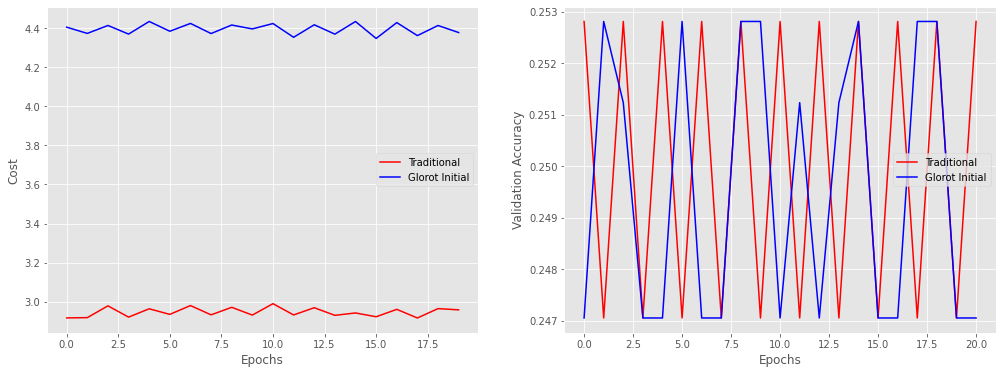

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_OverSmote.copy().to_numpy(), y_OverSmote.copy(), test_size=0.2, random_state=0)
analyze_two_layer_perceptron(X_train, y_train, X_test, y_test)

#### Normalize Numeric Feature Data
I first normalized the numeric data. To do this I utilized the l2 procedurer we had priorly learned, and I applied this to all of the numerical values in the dataset. L2 normalization is the least squares normalization, which modifies the data so that the sum of the squares of the data remains at 1 in every row. This allows for all of the data to be uniformly distrubutes in comparison to each other. I chose L2 because it optimizes the mean cost, which would improve my performance. 

In [15]:
#Normalize Continuous Numeric Feature Data
from sklearn.preprocessing import Normalizer 
normalizer = Normalizer(norm = 'l2')
X_OverSmote_Normal = normalizer.transform(X_OverSmote)

Upon normalizing the data, I ran a secondary test of the Two Layer perceptron. The accuracy remained more consistent, and the cost followed a consistent trend of the cost dropping progressively as the epochs continue.

Epoch: 20/20

CPU times: user 10.3 s, sys: 487 ms, total: 10.8 s
Wall time: 10.9 s


Epoch: 20/20

CPU times: user 10.3 s, sys: 518 ms, total: 10.8 s
Wall time: 10.9 s
Traditional :
Resubstitution acc: 0.24969122036573232
Validation acc: 0.25123507616303004
Glorot Initial :
Resubstitution acc: 0.25073764023741724
Validation acc: 0.247049540277206


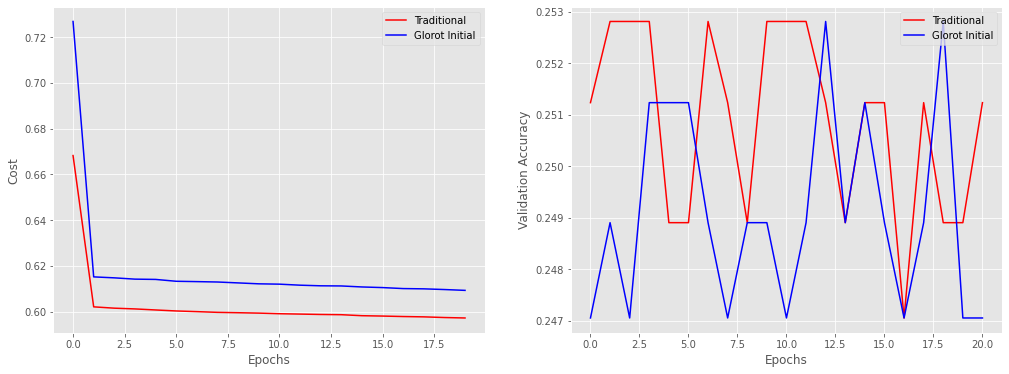

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_OverSmote_Normal.copy(), y_OverSmote.copy(), test_size=0.2, random_state=0)
analyze_two_layer_perceptron(X_train, y_train, X_test, y_test)

#### Normalize Continuous Numeric Feature Data
Next, I wanted to normalize the categorical data, so I one-hot encoded the categorical data using pandas built in get_dummies value. I ran it on the only two categorical values, state and counties. 

In [17]:
# one hot encode state and county
X_OverSmote_One_Hot = pd.concat((X_OverSmote,pd.get_dummies(X_OverSmote, columns=['County', 'State'])),1)

We can now see that one-hot encoding changed very little of the sporatic nature of the accuracy. However, it did tend to standardize the cost used per epoch, however, it remained conistently level. 

Epoch: 20/20

CPU times: user 2min 20s, sys: 49.6 s, total: 3min 10s
Wall time: 3min 12s


Epoch: 20/20

CPU times: user 2min 8s, sys: 46.7 s, total: 2min 55s
Wall time: 2min 56s
Traditional :
Resubstitution acc: 0.24929666861083474
Validation acc: 0.2528132290380129
Glorot Initial :
Resubstitution acc: 0.25073764023741724
Validation acc: 0.247049540277206


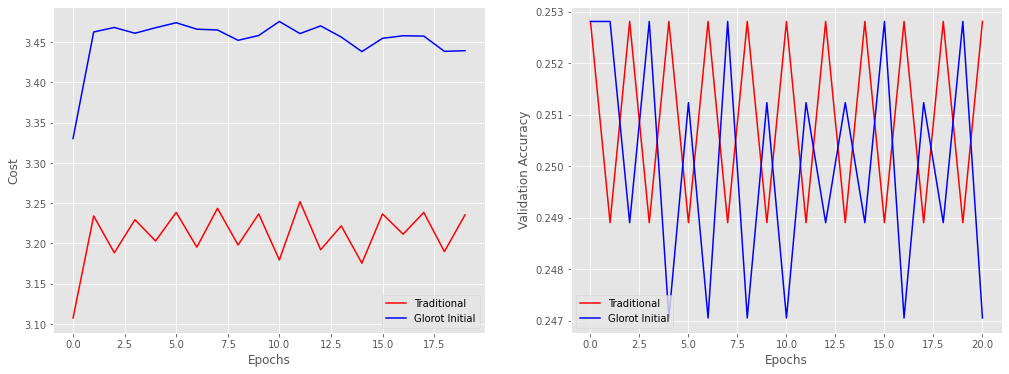

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_OverSmote_One_Hot.copy().to_numpy(), y_OverSmote.copy(), test_size=0.2, random_state=0)
analyze_two_layer_perceptron(X_train, y_train, X_test, y_test)

#### Normalize and One-Code Dataset

After comparing the affect of both one-hot encoding and normalization, we then want to combine them to create the maximum possible result. Resultantly, it takes around 1 epoch to drop the cost drastically, and the combine benefits bring the cost to a low of .6.

Epoch: 20/20

CPU times: user 1min 43s, sys: 40.6 s, total: 2min 24s
Wall time: 2min 24s


Epoch: 20/20

CPU times: user 1min 41s, sys: 39.8 s, total: 2min 21s
Wall time: 2min 21s
Traditional :
Resubstitution acc: 0.25073764023741724
Validation acc: 0.247049540277206
Glorot Initial :
Resubstitution acc: 0.25073764023741724
Validation acc: 0.247049540277206


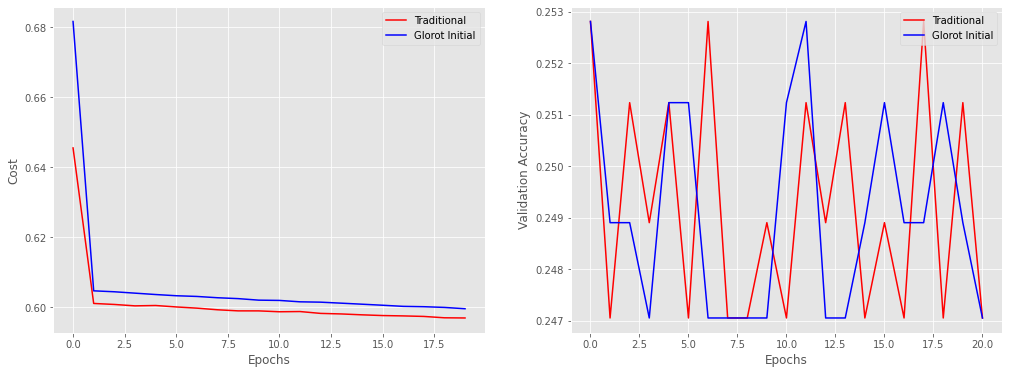

In [19]:
X_OverSmote = pd.concat((X_OverSmote,pd.get_dummies(X_OverSmote, columns=['County', 'State'])),1)
X_OverSmote = normalizer.transform(X_OverSmote)
X_train, X_test, y_train, y_test = train_test_split(X_OverSmote.copy(), y_OverSmote.copy(), test_size=0.2, random_state=0)
analyze_two_layer_perceptron(X_train, y_train, X_test, y_test)

#### Compare Performance
As we can see from above the normalization graph and the graph with normalization and one-hot encoding tend to be very similar. This is because county and state are a very small subportion of the data. Therefore, when one-hot encoding those two, it doesn't apply as great an affect to the greater cost. However, one our accuracy side, we can see that one-hot encoding tends to lead to higher peaks of accuracy but more sporatic results. Overall, I would conclude that the more important factor in this particular case would be normalization, as most of the data is numeric. 

### Modeling

To begin to create the multi-layer processor, I combined the above implementation of a Two Layer Perceptron into one class. I was then able to extend this class to develop the Multi Layer Perceptron. 

In [20]:
class TwoLayerPerceptron(object):
    def __init__(self, n_hidden=30, C=0.0, epochs=500, eta=0.001, random_state=None, alpha=0.0, decrease_const=0.0, shuffle=True, minibatches=1):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches
        
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
            
        return onehot

    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        # suggested relu/sigmoid bounds
        #Xavier Glorot, Yoshua Bengio ; 
        #  Understanding the difficulty of training deep feedforward neural networks
        #  Conference on Artificial Intelligence and Statistics, PMLR 9:249-256, 2010.
        init_bound = np.sqrt(2)*np.sqrt(6. / (self.n_hidden + self.n_features_ + 1))
        W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_features_ + 1))
        W1[:,:1] = 0
        
        # reduce the final layer magnitude in order to balance the size of the gradients
        # between 
        init_bound = 4*np.sqrt(6 / (self.n_output_ + self.n_hidden + 1))
        W2 = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden + 1)) 
        W2[:,:1] = 0
        
        return W1, W2
    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)
    
    @staticmethod
    def _relu(Z):
        return np.maximum(0, Z.copy())
    
    @staticmethod
    def _add_bias_unit(X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            ones = np.ones((X.shape[0], 1))
            X_new = np.hstack((ones, X))
        elif how == 'row':
            ones = np.ones((1, X.shape[1]))
            X_new = np.vstack((ones, X))
        return X_new
    
    @staticmethod
    def _L2_reg(lambda_, W1, W2):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_/2.0) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2))
    
    def _cost(self,A3,Y_enc,W1,W2):
        '''Get the objective function value'''
        cost = -np.mean(np.nan_to_num((Y_enc*np.log(A3)+(1-Y_enc)*np.log(1-A3))))
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term
    
    def _feedforward(self, X, W1, W2):
        """Compute feedforward step
        """
        # A1->W1->ReLu->A2->W2->Sigmoid
        A1 = self._add_bias_unit(X.T, how='row')
        Z1 = W1 @ A1
        A2 = self._relu(Z1)
        A2 = self._add_bias_unit(A2, how='row')
        Z2 = W2 @ A2
        A3 = self._sigmoid(Z2) # never use relu as last layer for classification (yuck!)
        return A1, Z1, A2, Z2, A3
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V2 = (A3-Y_enc) 
        
        # V3[Z2<=0] = 0 # could can change to be relu back prop on this layer too!
        
        # old update: V1 = A2*(1-A2)*(W2.T @ V2)
        # the derivative of sigmoid was A2(1-A2), but now that is relu
        # so we change it to:
        Z1_with_bias = self._add_bias_unit(Z1,how='row')
        V1 = (W2.T @ V2) 
        V1[Z1_with_bias<=0] = 0
        # relu derivative only zeros out certain values! easy!
        
        grad2 = V2 @ A2.T
        grad1 = V1[1:,:] @ A1.T
        
        
        # regularize weights that are not bias terms
        grad1[:, 1:] += (W1[:, 1:] * self.l2_C)
        grad2[:, 1:] += (W2[:, 1:] * self.l2_C)

        return grad1, grad2
    
    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, A3 = self._feedforward(X, self.W1, self.W2)
        y_pred = np.argmax(A3, axis=0)
        return y_pred
    
    def fit(self, X, y, print_progress=False, XY_test=None):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2 = self._initialize_weights()

        rho_W1_prev = np.zeros(self.W1.shape)
        rho_W2_prev = np.zeros(self.W2.shape)

        self.cost_ = []
        self.score_ = []
        # get starting acc
        self.score_.append(accuracy_score(y_data,self.predict(X_data)))
        # keep track of validation, if given
        if XY_test is not None:
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            self.val_score_ = []
            self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
            
        for i in range(self.epochs):

            # adaptive learning rate
            # \frac{\eta}{1+\epsilon\cdot k}
            eta = self.eta / (1 + self.decrease_const*i)

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:

                # feedforward
                A1, Z1, A2, Z2, A3 = self._feedforward(X_data[idx],
                                                       self.W1,
                                                       self.W2)
                
                cost = self._cost(A3,Y_enc[:, idx],self.W1,self.W2)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                grad1, grad2 = self._get_gradient(A1=A1, A2=A2, A3=A3, Z1=Z1, Z2=Z2, 
                                                  Y_enc=Y_enc[:, idx],
                                                  W1=self.W1,W2=self.W2)

                # momentum calculations
                rho_W1, rho_W2 = eta * grad1, eta * grad2
                self.W1 -= (rho_W1 + (self.alpha * rho_W1_prev))
                self.W2 -= (rho_W2 + (self.alpha * rho_W2_prev))
                rho_W1_prev, rho_W2_prev = rho_W1, rho_W2

            self.cost_.append(mini_cost)
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))
            if XY_test is not None:
                self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
            
        return self

After extending the class, I had to modify the functionality to include more than two layers. In order to do this, I had to create several more initialization values. I needed to be able to implement a value which could account for the number of layers the perceptron was suppose to hold. <br/>


Once the value is implemented, I need to address the weights for each layer. You could utilize essentially the same method to find the weight for each layer, but for each layer, you append the weight to an array of weights and an array of biases. For each, you reference the element in the array which contains the hidden layer's value, and you can calculate as was priorly done. <br/>


Now, because we have an array of weights and biases, we need to modify any method that utilizes the weights of each layer. The first value of this is the L2 regularization, where you need to calculate the mean squared for each weight in the array. Then you sum all the values together to find the result. <br/>


I then modified the feed forward method to create an array of outputs and hidden layers splits. I modified the bias to be added the the Z values, so that it could manage the changing layers. Otherwise, for each layer we could complete the same calculation and add it to the resulting arrays. <br/>


Next how we calculate the gradients needs to be addressed. Essentially the same calculations can be performed as priorly, but it must be done in a loop to accomidate the new array inputs. It then returns an array of gradients and gradient biases.<br/>


Finally, I had to modify the prediction function to accomidate sending the correct arrays to feedforward, and then pulling the maximum value as a return. <br/>


The last step was to address the fit function. Most of the calculations remained the same, but with the added step of allowing our gradient function to return arrays. Additionally, I had to include functionality to save the gradient, if it was requested. In order to do this, I simply went and set self.grad_ whenever the gradient was modified.

In [21]:
from functools import reduce

class MultiLayerPerceptron(TwoLayerPerceptron):
    def __init__(self, layers=2, save_grad = False, **kwds):        
        self.layers = layers
        self.save_grad = save_grad
        
        # but keep other keywords
        super().__init__(**kwds)
        
    def _initialize_weights(self):
        """Initialize weights Glorot and He normalization."""
        W = []
        b = []

        # create weights for input layer x hidden layer
        init_bound = 4*np.sqrt(6.0 / (self.n_hidden[0] + self.n_features_ + 1))
        W.append(np.random.uniform(-init_bound, init_bound, (self.n_hidden[0], self.n_features_)))
        b.append(np.zeros((self.n_hidden[0], 1)))

        # create weights for all hidden layer x hidden layer
        for i in range(0, self.layers - 2):
            init_bound = 4*np.sqrt(6.0 / (self.n_hidden[i] + self.n_hidden[i+1] + 1))
            W.append(np.random.uniform(-init_bound, init_bound, (self.n_hidden[i], self.n_hidden[i + 1])))
            b.append(np.zeros((self.n_hidden[i + 1], 1)))

        # create weights for hidden layer x output layer
        init_bound = 4*np.sqrt(6.0 / (self.n_hidden[-1] + self.n_output_ + 1))
        W.append(np.random.uniform(-init_bound, init_bound, (self.n_output_, self.n_hidden[-1])))
        b.append(np.zeros((self.n_output_, 1)))
            
        return W, b
    
    @staticmethod
    def _L2_reg(lambda_, W):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        LS_means = list(map(lambda w:np.mean(w ** 2),W))
        L2 = reduce(lambda a, b: a+b, LS_means)

        return (lambda_) * np.sqrt(L2)
    
    def _cost(self, A3, Y_enc, W):
        """Get the objective function value"""
        cost = -np.mean(np.nan_to_num((Y_enc*np.log(A3)+(1-Y_enc)*np.log(1-A3))))
        L2_term = self._L2_reg(self.l2_C, W)
        return cost + L2_term
    
    def _feedforward(self, X, W, b):
        """Compute feedforward step"""
        A = []
        Z = []

        A.append(X.T)
        Z.append(W[0] @ A[0] + b[0])

        for i in range(1, self.layers):
            A.append(self._sigmoid(Z[i - 1]))
            Z.append(W[i] @ A[i] + b[i])

        A.append(self._sigmoid(Z[-1]))

        return A, Z

    def _get_gradient(self, A, Z, Y_enc, W):
        """Compute gradient step using backpropagation."""
        V = [0] * self.layers
        V[-1] = (A[-1] - Y_enc)

        for i in range(self.layers - 1, 0, -1):
            V[i - 1] = A[i] * (1 - A[i]) * (W[i].T @ V[i])

        grad = [0] * self.layers
        gradb = [0] * self.layers

        for i in range(0, self.layers):
            grad[i] = V[i] @ A[i].T
            gradb[i] = np.sum(V[i], axis=1).reshape((-1,1))

        return grad, gradb
    
    def predict(self, X):
        """Predict class labels"""
        A, _ = self._feedforward(X, self.W, self.b)
        y_pred = np.argmax(A[-1], axis=0)
        return y_pred
    
    
    def fit(self, X, y, print_progress=False, XY_test=None):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W, self.b = self._initialize_weights()
        
        #functionality to save gradient at this current point
        if self.save_grad:
            self.grad_ = [np.zeros(self.epochs) for _ in range(self.layers)]

        self.cost_ = []
        self.score_ = []
        # get starting acc
        self.score_.append(np.mean(self.predict(X_data) == y_data))
        
        # keep track of validation, if given
        if XY_test is not None:
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            self.val_score_ = []
            self.val_score_.append(np.mean(self.predict(X_test) == y_test))
            
        for i in range(self.epochs):

            # adaptive learning rate
            eta = self.eta / (1 + self.decrease_const*i)
            eta = max(eta, self.eta / 1000)

            if print_progress>0 and (i+1) % print_progress==0:
                print('Epoch: %d/%d' % (i+1, self.epochs), end='\r')

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(np.arange(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:

                # feedforward
                A, Z = self._feedforward(X_data[idx], self.W, self.b)
                
                cost = self._cost(A[-1], Y_enc[:, idx], self.W)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                grad, gradb = self._get_gradient(A, Z, Y_enc[:, idx], self.W)

                #functionality to save gradient at this current point
                if self.save_grad:
                    for j in range(self.layers):
                        self.grad_[j][i] += np.mean(grad[j])
                
                for i in range(self.layers - 1):
                        self.W[i] -= eta * grad[i]
                        self.b[i] -= eta * gradb[i]
                        self.b[i] -= eta * gradb[i]
                        
            if self.save_grad:
                for j in range(self.layers):
                    self.grad_[j][i] = self.grad_[j][i] / self.minibatches

            self.cost_.append(mini_cost)
            self.score_.append(np.mean(self.predict(X_data) == y_data))
            if XY_test is not None:
                self.val_score_.append(np.mean(self.predict(X_test) == y_test))
                
        return self

I then created a function that would take the data and provide the accuracy and the cost of our new perceptron. Additionally, it shows the gradient magnitudes over time if we opted to save them. 

In [22]:
def analyze_perceptron(X_train, y_train, X_test, y_test, vals):
    nn = MultiLayerPerceptron(**vals)
    %time nn.fit(X_train, y_train, print_progress=1, XY_test=(X_test, y_test))

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(17, 6))

    print_result(nn,X_train,y_train,X_test,y_test, ax1, ax2, ax3)
    plt.show()
    
def print_result(nn,X_train,y_train,X_test,y_test, ax1, ax2, ax3):
    
    print("=================")
    yhat = nn.predict(X_train)
    print('Resubstitution acc:',accuracy_score(y_train,yhat))
    
    yhat = nn.predict(X_test)
    print('Validation acc:',accuracy_score(y_test,yhat))
    
    if hasattr(nn,'val_score_'):
        ax1.plot(range(len(nn.val_score_)), nn.val_score_)
        ax1.set_ylabel('Validation Accuracy')

    else:
        ax1.plot(range(len(nn.score_)), nn.score_)
        ax1.set_ylabel('Resub Accuracy')
        
    ax1.set_title('Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.grid(True)

    cost_avgs = [np.mean(x) for x in nn.cost_]

    ax2.plot(range(len(cost_avgs)), cost_avgs)
    ax2.set_title('Cost over epochs')
    ax2.set_ylabel('Cost')
    ax2.set_xlabel('Epochs')
    ax2.grid(True)
    
    print_gradient_magnitudes(nn, ax3)
    
#Graph the magniuted of the gradient over time utilizing the saved gradients
def print_gradient_magnitudes(nn, ax):
    if hasattr(nn,'grad_') != True:
        return

    for i in range(nn.layers):
        ax.plot(abs(nn.grad_[i]), label="Layer " + str(i + 1))

    ax.set_ylabel('Average gradient magnitude')
    ax.set_xlabel('Epochs')

#### Third Layer of Perceptron

Upon testing the above perceptron on a third layer, I saw that the cost continued to drop and follow the prior trend, but do so much more efficiently. 

CPU times: user 2min 9s, sys: 9.79 s, total: 2min 19s
Wall time: 2min 20s
Resubstitution acc: 0.25073764023741724
Validation acc: 0.247049540277206


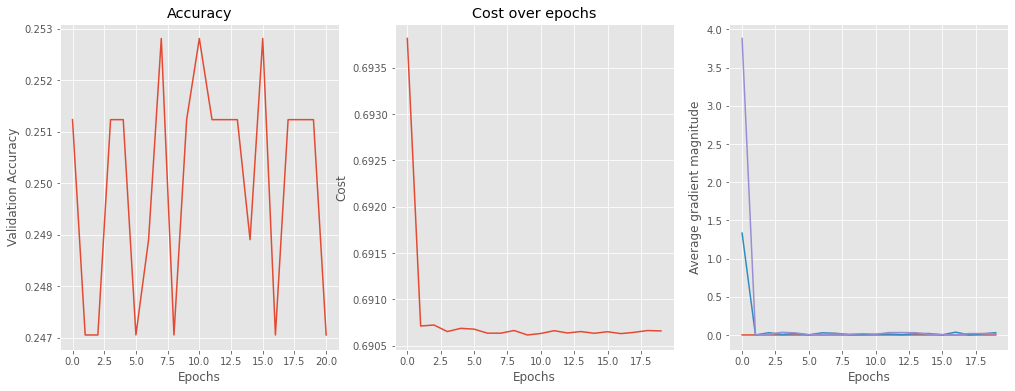

In [23]:
vals = {'layers':3, 'save_grad': True, 'n_hidden':[30, 30], 
        'C':0.1, 'epochs':20, 'eta':0.001, 
        'minibatches':len(X_train)/32,
        'shuffle':True,'random_state':1}
X_train, X_test, y_train, y_test = train_test_split(X_OverSmote.copy(), y_OverSmote.copy(), test_size=0.2, random_state=0)
analyze_perceptron(X_train, y_train, X_test, y_test, vals)

#### Fourth Layer of Perceptron

I then added a fourth layer layer creating an even more significant drop in costs. 

CPU times: user 2min 20s, sys: 9.75 s, total: 2min 30s
Wall time: 2min 30s
Resubstitution acc: 0.24969122036573232
Validation acc: 0.25123507616303004


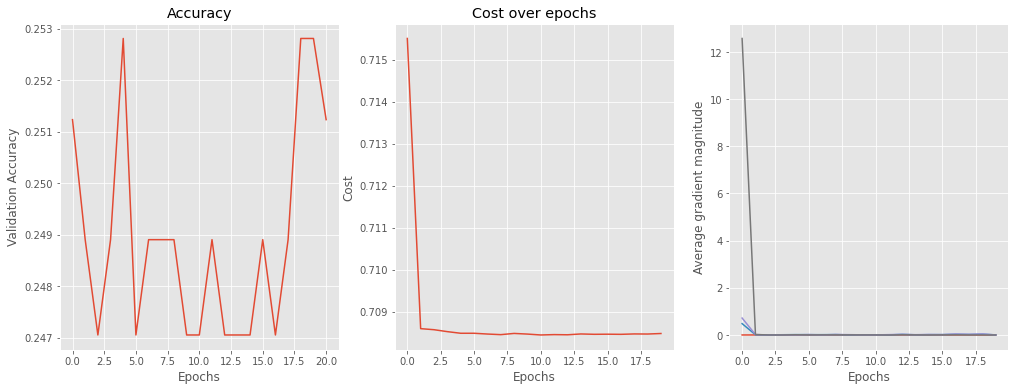

In [24]:
vals = {'layers':4, 'save_grad': True, 'n_hidden':[30, 30, 30], 
        'C':0.1, 'epochs':20, 'eta':0.001, 
        'minibatches':len(X_train)/32,
        'shuffle':True,'random_state':1}
X_train, X_test, y_train, y_test = train_test_split(X_OverSmote.copy(), y_OverSmote.copy(), test_size=0.2, random_state=0)
analyze_perceptron(X_train, y_train, X_test, y_test, vals)

#### Fifth Layer of Perceptron

Finally, I implemented a final, fifth layer to the perceptron, and I saw the the cost remained more or less like the prior model. 

CPU times: user 2min 30s, sys: 10.3 s, total: 2min 40s
Wall time: 2min 41s
Resubstitution acc: 0.25073764023741724
Validation acc: 0.247049540277206


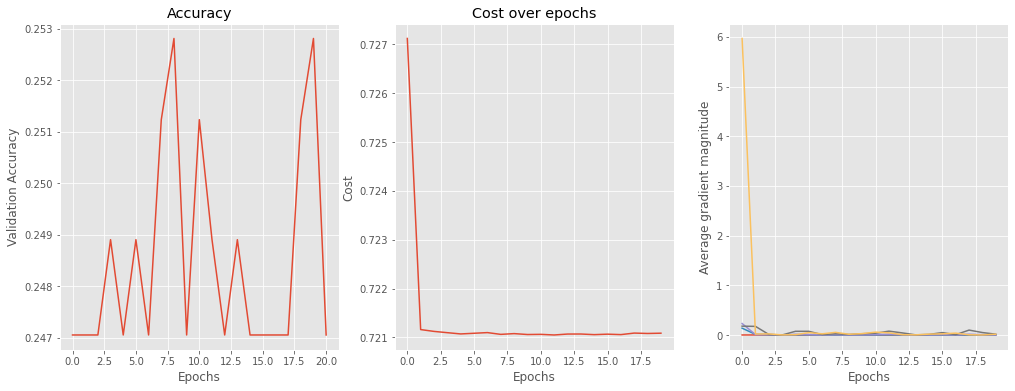

In [25]:
vals = {'layers':5, 'save_grad': True, 'n_hidden':[30, 30, 30, 30], 
        'C':0.1, 'epochs':20, 'eta':0.001, 
        'minibatches':len(X_train)/32,
        'shuffle':True,'random_state':1}
X_train, X_test, y_train, y_test = train_test_split(X_OverSmote.copy(), y_OverSmote.copy(), test_size=0.2, random_state=0)
analyze_perceptron(X_train, y_train, X_test, y_test, vals)

#### Adaptive Learning
To further improve my model, I implemented the RMSprop method, which stands for Root Mean Square Propagation. It is a gradient descent optimization algorithm, which utilizes exponential decay to improve the accuracy of the learning of our perceptron. 

In [31]:
class MultiLayerPerceptron_Adaptive(MultiLayerPerceptron):
    
    def __init__(self, gamma=0.0, epsilon=1e-8, **kwds):        
        self.gamma = gamma
        self.epsilon = epsilon
        
        # but keep other keywords
        super().__init__(**kwds)       
    
    def fit(self, X, y, print_progress=False, XY_test=None):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W, self.b = self._initialize_weights()
        
        #Allows for gradients to later be saved
        if self.save_grad:
            self.grad_ = [np.zeros(self.epochs) for _ in range(self.layers)]
            
        #Implementation of adaptive learning
        V_prev = [np.zeros(w.shape) for w in self.W]
        Vb_prev = [np.zeros(b.shape) for b in self.b]

        self.cost_ = []
        self.score_ = []
        # get starting acc
        self.score_.append(np.mean(self.predict(X_data) == y_data))
        
        # keep track of validation, if given
        if XY_test is not None:
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            self.val_score_ = []
            self.val_score_.append(np.mean(self.predict(X_test) == y_test))
            
        for i in range(self.epochs):

            # adaptive learning rate
            eta = self.eta / (1 + self.decrease_const*i)
            eta = max(eta, self.eta / 1000)

            if print_progress>0 and (i+1) % print_progress==0:
                print('Epoch: %d/%d' % (i+1, self.epochs), end='\r')

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(np.arange(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:

                # feedforward
                A, Z = self._feedforward(X_data[idx], self.W, self.b)
                
                cost = self._cost(A[-1], Y_enc[:, idx], self.W)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                grad, gradb = self._get_gradient(A, Z, Y_enc[:, idx], self.W)

                #Save gradient for later reference
                if self.save_grad:
                    for j in range(self.layers):
                        self.grad_[j][i] += np.mean(grad[j])
                
                #RMSprop for weightsb
                G = [w ** 2 for w in grad]
                V = [self.gamma * v + (1 - self.gamma) * g for v, g in zip(V_prev, G)]
                V_prev = V
                rho = [1 / np.sqrt(v + self.epsilon) * w for v, w in zip(V, grad)]

                # RMSprop for bias
                Gb = [w ** 2 for w in gradb]
                Vb = [self.gamma * v + (1 - self.gamma) * g for v, g in zip(Vb_prev, Gb)]
                Vb_prev = Vb
                rhob = [1 / np.sqrt(v + self.epsilon) * w for v, w in zip(Vb, gradb)]

                # update weights
                for i in range(self.layers - 1):
                    self.W[i] -= eta * rho[i]
                    self.b[i] -= eta * rhob[i]

                        
            if self.save_grad:
                for j in range(self.layers):
                    self.grad_[j][i] = self.grad_[j][i] / self.minibatches

            self.cost_.append(mini_cost)
            self.score_.append(np.mean(self.predict(X_data) == y_data))
            if XY_test is not None:
                self.val_score_.append(np.mean(self.predict(X_test) == y_test))
                
        return self

In [32]:
def analyze_perceptron(X_train, y_train, X_test, y_test, vals):
    nn = MultiLayerPerceptron_Adaptive(**vals)
    %time nn.fit(X_train, y_train, print_progress=1, XY_test=(X_test, y_test))

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(17, 6))

    print_result(nn,X_train,y_train,X_test,y_test, ax1, ax2, ax3)
    plt.show()

CPU times: user 3min 26s, sys: 10.3 s, total: 3min 37s
Wall time: 3min 38s
Resubstitution acc: 0.25073764023741724
Validation acc: 0.247049540277206


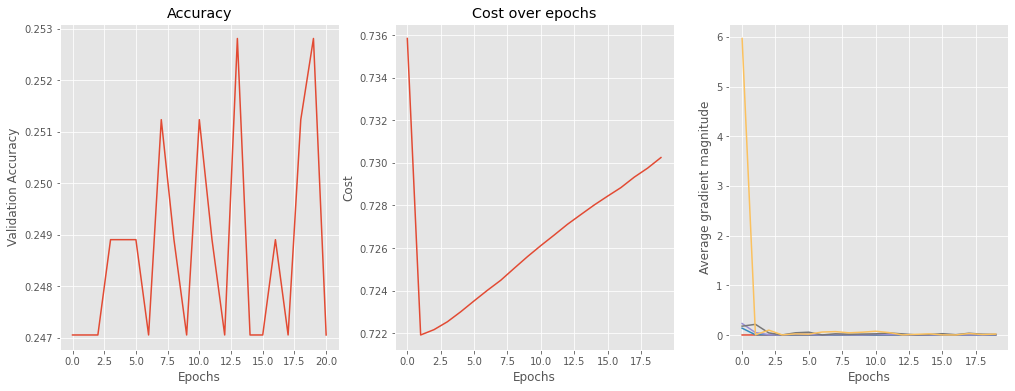

In [33]:
vals = {'gamma': 0.9, 'layers':5, 'save_grad': True, 'n_hidden':[30, 30, 30, 30], 
        'C':0.1, 'epochs':20, 'eta':0.001, 
        'minibatches':len(X_train)/32,
        'shuffle':True,'random_state':1}
X_train, X_test, y_train, y_test = train_test_split(X_OverSmote.copy(), y_OverSmote.copy(), test_size=0.2, random_state=0)
analyze_perceptron(X_train, y_train, X_test, y_test, vals)